# ECG Filtering via a data driven GP model 

In [54]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
import os
import sys

import wfdb

import time

import numpy as np
from numpy.linalg import norm
from numpy.linalg import inv
import random as rnd
import math as mth

import scipy.signal as scsig
import scipy.linalg as sclin
import matplotlib.pyplot as plt
# import scipy.stats as scstat
# import scipy.ndimage as scndi

## Plotting Functions

In [3]:
def func_plot_check(tm, pks, mids, s, ecg_clean, ecg_bwr, ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq):
    plt.figure(figsize=(18,20))
    
    plt.subplot(8, 1, 1).set_title('signal')
    plt.plot(s)
    
    plt.subplot(8, 1, 2).set_title('clean ecg [chunk of signal]')
    plt.plot(tm, ecg_clean)
    
    plt.subplot(8, 1, 3).set_title('ecg bw removed')
    plt.plot(tm, ecg_bwr)
    plt.plot(tm[pks], ecg_bwr[pks], 'o')
    plt.plot(tm[mids], ecg_bwr[mids], 'o')
    
    plt.subplot(8, 1, 4).set_title('ecg low BP filt')
    plt.plot(tm, ecg_bp1)
    
    plt.subplot(8, 1, 5).set_title('ecg high BP filt')
    plt.plot(tm, ecg_bp)
    
    plt.subplot(8, 1, 6).set_title('ecg tan filt [saturation]')
    plt.plot(tm, ecg_tan)
    
    plt.subplot(8, 1, 7).set_title('ecg sq filt')
    plt.plot(tm, ecg_sq)
    
    plt.subplot(8, 1, 8).set_title('ecg MA_sq filt')
    plt.plot(tm, ecg_MA_sq)
    plt.show()    

In [4]:
# def func_plot_comparison(xhbf_n, xhbf, s_hat, n, detail, name, noise_db, algo):
#     plt.figure(figsize=(18,10))    

#     plt.subplot(5,1,1)
#     plt.plot(xhbf_n)
#     plt.plot(s_hat)
#     plt.legend(['x', '$\hat{s}$'], loc = 'upper right', fontsize = 14)

#     plt.subplot(5,1,2)
#     plt.plot(xhbf)
#     plt.plot(s_hat)
#     plt.legend(['s', '$\hat{s}$'], loc = 'upper right', fontsize = 14)

#     plt.subplot(5,1,3)
#     plt.plot(n)
#     plt.plot(xhbf_n - s_hat)
#     plt.legend(['n','$\hat{n}$'], loc = 'upper right', fontsize = 14)

#     plt.subplot(5,1,4)
#     plt.plot(xhbf_n[0 : detail])
#     plt.plot(s_hat[0 : detail])
#     plt.legend(['x', '$\hat{s}$'], loc = 'upper right', fontsize = 14)

#     plt.subplot(5,1,5)
#     plt.plot(xhbf[0 : detail])
#     plt.plot(s_hat[0 : detail])
#     plt.legend(['s', '$\hat{s}$'], loc = 'upper right', fontsize = 14)

#     plt.savefig("EpsFigs/" + name + '_' + str(noise_db) + 'dB_' + algo +'.eps', 
#                 format = 'eps', 
#                 bbox_inches='tight', 
#                 transparent = False)
#     plt.show()

In [5]:
# def plot_tests(Theta, Rho, x_n_f, x_n, s_h, detail):
#     fig = plt.figure(figsize = (24, 12))
#     #----- ---- --- -- -
#     plt.subplot(3, 2, 1)
#     plt.imshow(Rho)
#     plt.colorbar()
#     plt.title(" Rho ")
#     #----- ---- --- -- -
#     H = Theta.T * Rho * Theta
#     plt.subplot(3, 2, 2)
#     plt.imshow(H[0 : detail, 0 : detail])
#     plt.colorbar()
#     plt.title(" Th' * Rho * Th ")
#     #----- ---- --- -- -
#     plt.subplot(3, 2, (3,4))
#     plt.plot(x_n_f[0 : detail], label = 'x_n_f')
#     plt.plot(x_f[0 : detail], label = 'x_f')
#     plt.plot(s_h[0 : detail], label = 's_h')
#     plt.legend()
#     #----- ---- --- -- -
#     plt.subplot(3, 2, 5)
#     plt.plot(x_n_f[0 : detail] - s_h[0 : detail], 
#              label = 'x_n_f - s_h')
#     plt.legend()
#     #----- ---- --- -- -
#     plt.subplot(3, 2, 6)
#     plt.plot(x_f[0 : detail] - s_h[0 : detail], 
#              label = 'x_f - s_h')
#     plt.legend()
#     #----- ---- --- -- -
#     fig.tight_layout()
#     plt.show()    

In [6]:
def plot_all(x, xph, var_xph, var_n, diagRho, mu_xph, s, tit1, tit2, detail):
    fig = plt.figure(figsize = (22, 10))
    plot_ecg(x, tit1, 4, 1)
    plot_ecg(xph, tit2, 4, 2)
    plot_vars(var_xph, var_n, diagRho, mu_xph, tit2, 4, 3)
    plot_comp(x, s, 4, 4, detail)
    fig.tight_layout()
    plt.show()

In [7]:
def plot_transition(x, xph, mu_xph, var_xph):
    fig = plt.figure(figsize = (22, 4))
    plt.subplot(1, 3, 1)
    for i in np.arange(len(x)):
        plt.plot(x[i])
    plt.title('heartbeats')
    #-----
    plt.subplot(1, 3, 2)
    for i in np.arange(len(xph)):
        plt.plot(xph[i])
    plt.title('heartbeats ph')
    #-----
    plt.subplot(1, 3, 3)
    plt.plot(mu_xph, lw = 3, color = 'magenta')
    plt.fill_between(np.arange(len(mu_xph)),
                     np.concatenate(mu_xph, axis=0) - var_xph,
                     np.concatenate(mu_xph, axis=0) + var_xph,
                     color = 'gray',
                     alpha = 0.2)
    plt.title('average heartbeat ph')
    fig.tight_layout()
    plt.savefig('Figs/pISCE_GP_Trans.eps', format = 'eps', bbox_inches='tight')
    plt.savefig('Figs/pISCE_GP_Trans.png', format = 'png', bbox_inches='tight')    
    plt.show()

In [8]:
def plot_transitionFS(x, xph, mu_xph, var_xph, fs):
    fig = plt.figure(figsize = (22, 4))
    plt.subplot(1, 3, 1)
    for i in np.arange(len(x)):
        plt.plot(np.arange(len(x[i]))/fs, x[i])
    plt.title('heartbeats')
    #-----
    plt.subplot(1, 3, 2)
    for i in np.arange(len(xph)):
        plt.plot(np.arange(len(xph[i]))/fs, xph[i])
    plt.title('heartbeats ph')
    #-----
    plt.subplot(1, 3, 3)
    plt.plot(np.arange(len(mu_xph))/fs, mu_xph, lw = 3, color = 'magenta')
    #plt.fill_between(np.arange(len(mu_xph)),
    #                 np.concatenate(mu_xph, axis=0) - var_xph,
    #                 np.concatenate(mu_xph, axis=0) + var_xph,
    #                 color = 'gray',
    #                 alpha = 0.2)
    plt.title('average heartbeat ph')
    fig.tight_layout()
    plt.savefig('Figs/pISCE_GP_TransFS.eps', format = 'eps', bbox_inches='tight')
    plt.savefig('Figs/pISCE_GP_TransFS.png', format = 'png', bbox_inches='tight')
    plt.show()

In [9]:
def plot_transitionFS2(x, xph, mu_xph, var_xph, fs, target):
    x_f = np.concatenate(x, axis=0).tolist()  
    fig = plt.figure(figsize = (22, 8))
    plt.subplot(2, 2, 1)    
    plt.title('ECG', fontsize = 16)
    plt.xlabel("time [seconds]", fontsize = 16)
    plt.ylabel("amp [mV]", fontsize = 16)
    plt.plot(np.arange(len(x_f[0:8000]))/fs, x_f[0:8000])

    #-----
    plt.subplot(2, 2, 3)
    plt.title('heartbeats', fontsize = 16)
    plt.xlabel("time [seconds]", fontsize = 16)
    plt.ylabel("amp [mV]", fontsize = 16)    
    for i in np.arange(len(x)):
        plt.plot(np.arange(len(x[i]))/fs, x[i])
    #-----
    plt.subplot(2, 2, 4)
    plt.title('heartbeats phase', fontsize = 16)
    plt.xlabel("time [seconds]", fontsize = 16)
    plt.ylabel("amp [mV]", fontsize = 16)    
    for i in np.arange(len(xph)):
        plt.plot(np.arange(len(xph[i]))/fs, xph[i])
    #-----
    plt.subplot(2, 2, 2)
    plt.title('average heartbeat phase', fontsize = 16)
    plt.xlabel("time [seconds]", fontsize = 16)
    plt.ylabel("amp [mV]", fontsize = 16)    
    plt.plot(np.arange(len(mu_xph))/fs, mu_xph, lw = 3, color = 'magenta')
    plt.fill_between(np.arange(len(mu_xph))/fs,
                     np.concatenate(mu_xph, axis=0) - var_xph,
                     np.concatenate(mu_xph, axis=0) + var_xph,
                     color = 'gray',
                     alpha = 0.2)
    fig.tight_layout()
    plt.savefig(target + '.eps', format = 'eps', bbox_inches='tight')
    plt.savefig(target + '.png', format = 'png', bbox_inches='tight')
    plt.show()

In [10]:
def plot_ecg(signal, tit, i, line):
    #-----
    plt.subplot(i, 3, 3 * (line-1) + 1)
    plt.plot(np.concatenate(signal, axis=0).tolist(), 
             label = 'l2 = ' + str(norm(np.concatenate(signal, axis=0).tolist(), 2)))
    plt.title(tit)
    plt.legend(fontsize = 13, 
               loc = 'upper right')
    #-----
    plt.subplot(i, 3,  3 * (line-1) + 2)
    plt.plot(signal[0])
    plt.title(tit + ' one hb')
    #-----
    plt.subplot(i, 3,  3 * (line-1) + 3)
    for i in np.arange(len(x)):
        plt.plot(signal[i])
    plt.title(tit + ' all hbs')
    #-----

In [11]:
def plot_vars(var_xph, var_n, diagRho, mu_xph, tit, i, line):
    #-----
    plt.subplot(i, 3, 3 * (line-1) + 1)
    plt.plot(var_xph, 
             label = 'var_' + tit)
    plt.plot(var_n * np.ones(len(var_xph)), 
             label = 'var_n = ' + str("{:.4f}".format(var_n)))
    plt.legend(fontsize = 13, 
               loc = 'upper right')
    plt.title('var_' + tit)    
    #-----
    plt.subplot(i, 3, 3 * (line-1) + 2)
    plt.plot(diagRho, 
             label = 'diag')
    plt.legend(fontsize = 13, 
               loc = 'upper right')
    plt.title("Rho diag")
    #-----
    plt.subplot(i, 3, 3 * (line-1) + 3)
    plt.plot(mu_xph,
             lw = 3,
             color = 'magenta',
             label = 'l2 = ' + str("{:.4f}".format(norm(mu_xph))))
    plt.fill_between(np.arange(len(mu_xph)),
                     np.concatenate(mu_xph, axis=0) - var_xph,
                     np.concatenate(mu_xph, axis=0) + var_xph,
                     color = 'gray',
                     alpha = 0.2)
    plt.legend(fontsize = 13, 
               loc = 'upper right')
    plt.title('mu_' + tit)    
    #-----

In [12]:
def plot_ThThT(Theta, Rho, st, en):
    ThThT = np.matmul(Theta, Theta.T) 
    Filt = np.matmul(np.matmul(Theta.T, Rho), Theta)
    fig = plt.figure(figsize = (22,5))    
    #-----
    plt.subplot(1,4,1)
    plt.imshow(Rho)
    plt.colorbar()
    plt.title("Rho")
    #-----
    plt.subplot(1,4,2)
    plt.imshow(ThThT)
    plt.colorbar()
    plt.title("Theta * Theta.T")    
    #-----
    plt.subplot(1,4,3)
    plt.imshow(ThThT[st:en,st:en])
    plt.colorbar()
    plt.title("Theta * Theta.T detail")        
    #-----
    plt.subplot(1,4,4)
    plt.imshow(Filt[st:en,st:en])
    plt.colorbar()
    plt.title("Filt detail")         
    #-----
    fig.tight_layout()

In [13]:
def plot_comp(x, s, i, line, detail):
    plt.subplot(i, 1, 4)        
    plt.plot(np.concatenate(x, axis=0).tolist()[0 : detail], label = 'x')
    plt.plot(s[0 : detail], label = 's')
    plt.legend(fontsize = 14,
              loc = 'upper right')
    plt.title("comparison")

In [14]:
def plot_sample_covariances(S_xph, var_xph, S_sph, var_sph, st, en):
    fig = plt.figure(figsize = (22,9))    
    #-----
    plt.subplot(2,3,1)
    plt.title('Samp Cov x_ph')
    plt.imshow(S_xph)
    plt.colorbar()
    #-----
    plt.subplot(2,3,2)
    plt.title('Samp Cov x_ph [detail]')
    plt.imshow(S_xph[st:en, st:en])
    plt.colorbar()
    #-----
    plt.subplot(2,3,3)
    plt.title('var x_ph')
    plt.plot(var_xph)
    #-----
    plt.subplot(2,3,4)
    plt.title('Samp Cov s_ph')
    plt.imshow(S_sph)
    plt.colorbar()
    #-----
    plt.subplot(2,3,5)
    plt.title('Samp Cov s_ph [detail]')
    plt.imshow(S_sph[st:en, st:en])
    plt.colorbar()
    #-----
    plt.subplot(2,3,6)
    plt.title('var s_ph')
    plt.plot(var_sph)
    #-----
    fig.tight_layout()

## Functions

In [15]:
# MOVING AVERAGE FILTER function
# filter window's length win_l expressed in seconds
def func_MA_filter(signal, win_l_MA, fs):
    win_len = int(win_l_MA * fs)
    signal_filtered = np.convolve(signal, np.ones(win_len)/win_len, mode='same')
    return signal_filtered

In [16]:
# MEDIAN FILTER function
# filter window's length win_l expressed in seconds!
def func_MD_filter(signal, win_l_MD, fs):
    win_len = int(win_l_MD * fs)
    signal_filtered = scsig.medfilt(signal, win_len)
    return signal_filtered

In [17]:
# BASELINE WANDER EXTRACTION
# function for baseline wander extraction. Based on a moving average (MA) and median (MD) filter.
# the original signal is filtered with a MA filter, then with a MD filter. 
# the filtered signal is the difference between the original signal and the double filtered signal.
def func_bw_extraction_MAMD(signal, win_l_MA, win_l_MD, fs):
    signal = signal - np.mean(signal)
    win_len_MA = int(win_l_MA * fs)
    win_len_MD = int(win_l_MD * fs)
    bw = func_MD_filter(func_MA_filter(signal, win_l_MA, fs), win_l_MD, fs)
    signal_bwr = signal - bw
    return(bw, signal_bwr)

In [18]:
def func_interpolate_nans(signal):
    nan_inds = np.isnan(signal)
    non_nan_inds = np.logical_not(nan_inds)
    non_nan_sig = signal[non_nan_inds]
    interpolated = np.interp(nan_inds.nonzero()[0], non_nan_inds.nonzero()[0], non_nan_sig)
    signal[nan_inds] = interpolated
    return signal

In [19]:
def func_BP_filter(signal, k_BP, fc):
    alpha = (1 - k_BP*np.cos(2*np.pi*fc) - np.sqrt(2*k_BP*(1-np.cos(2*np.pi*fc)) - k_BP**2 * np.sin(2 * np.pi * fc)**2))/(1-k_BP)
    signal_f = scsig.filtfilt(1-alpha, [1, -alpha], signal)
    return(signal_f)

In [20]:
def func_detect_peaks(signal, frac, win_l_calib, win_l_peak_search, fs):        
    k_BP = .7     # cut-off value
    flc = 15/fs
    ecg_bp1 = func_BP_filter(signal, k_BP, flc)    
    #
    k_BP = .7     # cut-off value    
    fuc = 45/fs
    ecg_bp = func_BP_filter(ecg_bp1, k_BP, fuc)
    #
    k_tan = 4
    alpha = k_tan * np.std(ecg_bp)
    ecg_tan = alpha*np.tanh(ecg_bp/alpha)
    #
    #ecg_sq = ecg_tan**2
    ecg_sq = np.abs(ecg_tan)
    #
    wind_len_MA = .1
    ecg_MA_sq = ecg_sq
    #ecg_MA_sq = np.sqrt(func_MA_filter(ecg_sq, wind_len_MA, fs))
    #
    maxecg = max(ecg_MA_sq)
    heightlim = frac * maxecg
    peaks, _ = scsig.find_peaks(ecg_MA_sq, distance = win_l_peak_search*fs, height = heightlim)            
    #
    #print("peaks raw (as per the detector)", peaks)
    wind_len_hf = int(win_l_calib * fs)
    pks = []
    for i in range(len(peaks)):
        if(i == 0):
            wind = np.arange(peaks[i], peaks[i]+wind_len_hf, 1)
            ecg_bwr_win = signal[wind]
            p = peaks[i] + np.argmax(ecg_bwr_win**2)   
        elif(i == len(peaks) - 1):
            wind = np.arange(peaks[i] - wind_len_hf, peaks[i], 1)            
            ecg_bwr_win = signal[wind]
            p = peaks[i]- wind_len_hf + np.argmax(ecg_bwr_win**2)                
        else:
            wind = np.arange(peaks[i] - wind_len_hf, peaks[i] + wind_len_hf, 1)
            ecg_bwr_win = signal[wind]
            p = peaks[i]- wind_len_hf + np.argmax(ecg_bwr_win**2)                            
        pks.append(p)    

    return(ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq, peaks, np.array(pks))

In [21]:
# MIDDLE DETECTION
# I am using this convention that a heartbeat is starting at the middle point between two R peaks and ends up
# at the middle point between the next two R peaks. 
def func_detect_middles(peaks,signal_length):
    mids = []
    for i in range(len(peaks)-1):        
        mid = peaks[i] + int(np.floor((peaks[i+1] - peaks[i])/2))
        mids.append(mid)
        
    mid = peaks[0] - int(np.floor((peaks[1] - peaks[0])/2))
    if(mid >= 0):
        mids.insert(0, mid)
    
    mid = peaks[-1] + int(np.floor((peaks[-1] - peaks[-2])/2))
    if(mid <= signal_length):
        mids.append(mid)        
    mids = np.array(mids)    
    return mids    

In [22]:
def func_reorder_peaks(peaks,mids):
    if(peaks[0]<mids[0] and peaks[-1]>mids[-1]):
        pks = peaks[1:-1]
        #print("case 1")
    elif(peaks[0]<mids[0]):
        pks = peaks[1:]
        #print("case 2")    
    elif(peaks[-1]>mids[-1]):
        pks = peaks[:-1]
        #print("case 3")    
    else:
        pks = peaks
    return(pks)

In [23]:
def func_heartbeats(ecg_bwr, mids):
    x_hbs = []
    for i in range(len(mids)-1):
        x_hb = ecg_bwr[mids[i]:mids[i+1]]
        x_hbs.append(x_hb)
    return(x_hbs)    

In [24]:
# def set_start(i, bin_len):
#     if ((i * bin_len) != 0 and (i * bin_len).is_integer() == True):
#         chunk_start = int(np.ceil(i * bin_len))+1
#     else:
#         chunk_start = int(np.ceil(i * bin_len))
#     return chunk_start

In [25]:
# def func_mapping(seg, Tau):
#     mapped_seg = []
#     bin_len = len(seg) / Tau
#     #print("bin lenght:", bin_len)
#     Theta = np.asmatrix(np.zeros((Tau, len(seg))))
#     for i in np.arange(Tau):
#         chunk_start = set_start(i, bin_len)
#         chunk_end = np.minimum(len(seg), int(np.floor((i+1) * bin_len)) + 1)        
#         chunk = seg[chunk_start : chunk_end]                
#         if(len(chunk) == 0): 
#             ratio = np.nan
#         else:    
#             ratio = np.sum(chunk) / np.sqrt(len(chunk))
#         #print(i, chunk_start, chunk_end, ratio)
#         mapped_seg.append(ratio)
#         Theta[i, chunk_start : chunk_end] = 1    
#     return mapped_seg, Theta

In [26]:
# def func_sig_phased(xhb, pshb, Tau):
#     yhb = []
#     Theta = []
#     for i, hb in enumerate(xhb):
#         y1, Th1 = func_mapping(hb[:pshb[i]], int(Tau/2))
#         y2, Th2 = func_mapping(hb[pshb[i]:], int(Tau/2))
#         y = np.concatenate([y1, y2])
#         Th = np.asmatrix(sclin.block_diag(Th1, Th2))
#         #Th = func_correct_Th(Th)
#         Th = Th / np.sqrt(Th.sum(1))
#         y = func_interpolate_nans(y)
#         yhb.append(y)
#         Theta.append(Th)
#     return yhb, Theta

In [27]:
def func_add_noise(target_snr_db, s):
    s = np.asanyarray(s)
    var_n = np.mean(s**2) / (10**(target_snr_db/10))
    n = np.random.normal(0, np.sqrt(var_n), len(s))    
    s_n = s + n # noise up the original signal
    return s_n, n, var_n

In [28]:
# def get_min_max(x):
#     lenghts = []
#     for hb in x:
#         lenghts.append(len(hb))
#     return np.min(lenghts), np.max(lenghts)

### Phase domain: signal in phase domain, transformation matrix

In [29]:
def get_sigphase_and_transfmat(x, pshb, Tau):
    xph = []
    Theta = []
    for i, hb in enumerate(x):
        hb1 = hb[0:pshb[i]]
        Th1, hb1_ph = get_theta_and_phase(hb1, int(Tau/2))
        #----- ---- --- -- -    
        hb2 = hb[pshb[i]:]
        Th2, hb2_ph = get_theta_and_phase(hb2, int(Tau/2))
        #----- ---- --- -- -            
        # fabricate the phase heartbeat as concatenation
        hb_ph = np.concatenate([hb1_ph, hb2_ph])        
        # fabricate the Th as diagonal concatenation
        Th = np.zeros((Th1.shape[0] + Th2.shape[0], Th1.shape[1] + Th2.shape[1]))
        Th[0 : Th1.shape[0], 0 : Th1.shape[1]] = Th1
        Th[Th1.shape[0] : Th1.shape[0] + Th2.shape[0], Th1.shape[1] : Th1.shape[1] + Th2.shape[1]] = Th2    
        Th = Th/np.sqrt(Th.sum(axis=1)[:,None])
        #----- ---- --- -- -        
        xph.append(hb_ph) 
        Theta.append(Th)      
    return xph, Theta

In [30]:
def get_theta_and_phase(hb, Tau):
    #print(len(hb), Tau)
    ints = get_intervals(len(hb), Tau)
    #---
    T = np.zeros((Tau, len(hb)))
    hbph = [] * Tau
    #---
    for i in np.arange(Tau):
        start = int(np.ceil(ints[i]))
        end = int(np.ceil(ints[i+1]))
        if(start == end):
            if(start > 0):
                start = start - 1
            if(end < len(hb)):
                end = end + 1
        T[i, np.arange(start, end)] = 1/np.sqrt(len(hb[start:end]))
        hbph.append(sum(hb[start:end])/np.sqrt(len(hb[start:end])))
    return T, hbph

In [31]:
def get_intervals(n,m):
    step = n / (m+1)
    ints = []
    for i in np.arange(m + 1):
        ints.append(i * step)
    return ints

In [32]:
def create_Theta(Th):
    Theta = Th[0].tolist()
    for i in np.arange(len(Th)-1):
        Theta = np.concatenate((Theta,Th[i+1].tolist()), axis = 1)
    Theta = np.asmatrix(Theta)
    Theta = Theta / np.sqrt(len(Th))
    return Theta

### Phase domain: signal in phase domain, transformation matrix (General)

In [33]:
def get_sigphase_and_transfmat2(x, pshb, Tau):
    xph = []
    Theta = []
    for i, hb in enumerate(x):
        hb1 = hb[0:pshb[i]]
        Th1, hb1_ph = get_theta_and_phase2(hb1, int(Tau/2))
        #----- ---- --- -- -    
        hb2 = hb[pshb[i]:]
        Th2, hb2_ph = get_theta_and_phase2(hb2, int(Tau/2))
        #----- ---- --- -- -            
        # fabricate the phase heartbeat as concatenation
        hb_ph = np.concatenate([hb1_ph, hb2_ph])        
        # fabricate the Th as diagonal concatenation
        Th = np.zeros((Th1.shape[0] + Th2.shape[0], Th1.shape[1] + Th2.shape[1]))
        Th[0 : Th1.shape[0], 0 : Th1.shape[1]] = Th1
        Th[Th1.shape[0] : Th1.shape[0] + Th2.shape[0], Th1.shape[1] : Th1.shape[1] + Th2.shape[1]] = Th2    
        Th = Th/np.sqrt(Th.sum(axis=1)[:,None])
        #----- ---- --- -- -        
        xph.append(hb_ph) 
        Theta.append(Th)      
    return xph, Theta

In [34]:
def get_theta_and_phase2(hb, Tau):
    #print(len(hb), Tau)
    ints = get_intervals(len(hb), Tau)
    #---
    T = np.zeros((Tau, len(hb)))
    hbph = [] * Tau
    #---
    for i in np.arange(Tau):
        start = int(np.ceil(ints[i]))
        end = int(np.ceil(ints[i+1]))
        if(start == end):
            if(start > 0):
                start = start - 1
            if(end < len(hb)):
                end = end + 1
        T[i, np.arange(start, end)] = 1/len(hb[start:end])
        hbph.append(sum(hb[start:end])/len(hb[start:end]))
    return T, hbph

In [35]:
def create_Theta2(Th):
    Theta = Th[0].tolist()
    for i in np.arange(len(Th)-1):
        Theta = np.concatenate((Theta,Th[i+1].tolist()), axis = 1)
    #Theta = np.asmatrix(Theta)
    Theta = Theta / len(Th)
    return Theta

### Covariance computation, variance estimations

In [36]:
def compute_covariance(x, var):    
    S_x = np.cov(x, 
                 rowvar = False, 
                 bias = True)
    S_s = S_x - var * np.identity(S_x.shape[0])
    var_x = np.diag(S_x)
    var_s = np.diag(S_s)    
    #-----
    return S_x, S_s, var_x, var_s

In [37]:
# def compute_covariance_v2(x, var):    
#     s = list(sum(x))
#     samps = []
#     for i in np.arange(len(xph_n)):
#         samp = (s - x[i])/(np.sqrt(len(x)-1))
#         samps.append(samp)
#     #----- ---- --- -- -    
#     S_x = np.cov(samps, 
#                  rowvar = False, 
#                  bias = True)
#     S_s = S_x - var * np.identity(S_x.shape[0])
#     var_x = np.diag(S_x)
#     var_s = np.diag(S_s)  
#     #-----
#     return samps, S_x, S_s, var_x, var_s

In [38]:
def compute_var_n_ME_v1(x, mu_xph):
    var_n_ME = np.abs(sum(i*i for i in x) - sum(i*i for i in mu_xph)[0]) / (len(x)-len(mu_xph))
    return var_n_ME

In [39]:
# def compute_sigma_n_ME_v2(xhbf_n, myhb_n, invSx):
#     a = np.trace(invSx) - norm(invSx*myhb_n, 2)**2
#     b = len(xhbf_n) - len(myhb_n)
#     c = norm(xhbf_n, 2)**2 - norm(myhb_n, 2)**2    
#     sig_n_est_n_ME_1 = (b + np.sqrt(b**2 - 4*a*c)) / (2 * (a))
#     sig_n_est_n_ME_2 = (b - np.sqrt(b**2 - 4*a*c)) / (2 * (a))        
#     return sig_n_est_n_ME_1, sig_n_est_n_ME_2

### Filter

In [40]:
def compute_GP_filter(Theta, Rho, sig, mu):    
    s_h = Theta.T * Rho * Theta * np.asmatrix(sig - mu).T + np.asmatrix(mu).T
    s_h = np.asarray(list(np.concatenate(s_h.tolist()).flat))
    return s_h

In [41]:
def func_MA_filter_time_phase_matrix(M_ph, n):    
    M_ph_sm = np.copy(M_ph)
    for i in range(M_ph.shape[0]):
        sig = np.asarray(M_ph[i,])
        sig = [item for sublist in sig.tolist() for item in sublist]
        M_ph_sm[i,] = func_MA_filter(sig, n, 1)
    return M_ph_sm  

In [42]:
def compute_all_SNRs(x_f, n, s_h):
    input_SNR_db = func_SNR_computation(x_f, n)
    output_SNR_db = func_SNR_computation(x_f, (s_h - x_f))
    delta_SNR_db = output_SNR_db - input_SNR_db
    return input_SNR_db, output_SNR_db, delta_SNR_db

In [43]:
def func_SNR_computation(s, n):
    s = np.asanyarray(s)
    n = np.asanyarray(n)
    snr = 10 * np.log10(np.mean(s**2)/np.mean(n**2))
    return snr

### Addendum

In [44]:
def check_if_diag(Matrix):
    if(np.count_nonzero(Matrix - np.diag(np.diagonal(Matrix)))==0):
        return True
    else:
        return False

In [45]:
def check_matrix_characteristics(Matrix):
    print('Checking matrix characteristics started....')
    if (check_if_diag(Matrix)==True):
        print('   Matrix is diagonal.')
    else:
        print('   Matrix is NOT diagonal.')

    if (np.linalg.det(Matrix)==0):
        print('   Matrix is NON invertible.')
    else:
        print('   Matrix is invertible.')
    print('Checking matrix characteristics finished.')        

In [46]:
def min_max_len_hb(x):
    minhb = len(x[0])
    maxhb = len(x[0])
    for i in np.arange(1,len(x)):
        if minhb>len(x[i]):
            minhb = len(x[i])
        if maxhb<len(x[i]):
            maxhb = len(x[i])        
    return minhb, maxhb

In [47]:
def func_alarm_ThThT(x, Tau):
    if (Tau <= min_max_len_hb(x)[0]):
        print('[OK] Tau =', Tau, '<=', min_max_len_hb(x)[0], '= min(len(hb)) => Theta * Theta.T is diagonal hence invertible.')
    else:
        print('[ALARM!] Tau =', Tau, '>', min_max_len_hb(x)[0], '= min(len(hb)) => Theta * Theta.T can be singular.')

In [48]:
def func_alarm_SampCov(x, Tau):
    if (Tau <= len(x)):
        print('[OK] Tau =', Tau, '<=', len(x), '= n_hb => sampCov most probably invertible')
    else:
        print('[ALARM!] Tau =', Tau, '>', len(x), '= n_hb => sampCov is singular (not enough heartbeats to produce a sample covariance matrix).')

## Filtering procedure

In [49]:
#srecord = wfdb.rdrecord('Data/s0010_re')
FILE_PATH = os.getcwd()
data_dir = FILE_PATH + '/../QTDataBase/'
data_files = os.listdir(data_dir) # get a listing of the directory
dat_files = [x.split('.')[0] for x in data_files]
#dat_files = sorted([f for f in data_files if f.endswith('.hea')]) # get a list of all the .atc files
#-------
file_name = 'sele0612'
#'sele0603' 'sele0612' 'sel41' 'sele0122' 'sel40' 'sele0612' 'sele0303'
#-------
file_to_read = data_dir + file_name
signals, fields = wfdb.rdsamp(file_to_read, sampfrom=0)
fs = fields["fs"]
ch_num = 0
s = signals[:,ch_num]
#
#-------
n_sec = 200
N = n_sec * fs 
ecg_clean = s[0: N]
tm = np.arange(0, N)/fs
#-------
bwr, ecg_bwr = func_bw_extraction_MAMD(signal = ecg_clean,
                                       win_l_MA = 0.5,
                                       win_l_MD = 0.71,
                                       fs = fs)
ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq, peaks2, pks = func_detect_peaks(signal = ecg_bwr, 
                                                                             frac = 0.5, 
                                                                             win_l_calib = 0.6, 
                                                                             win_l_peak_search = 0.5, 
                                                                             fs = fs)
mids = func_detect_middles(peaks2, len(ecg_bwr))
pks = func_reorder_peaks(pks, mids)

ecg = ecg_bwr[mids[0]:mids[-1]+1]                           # get the ecg, i.e. get the chunck between the first mid and last mid
ps = np.int_(pks - mids[0])                                 # calibrate the peaks, by shifting with the mids[0] 
                                                            # which is the begining of the signal
    
ms = np.int_(mids - mids[0])                                # calibrate the midles, by shifting with the mids[0] 
                                                            # which is the begining of the signal

pshb = ps - ms[:-1]                                         # the peaks relative to each heartbeat, i.e. the position counting 
                                                            # from the heartbeat begining    
#----- ---- --- -- -
target_noise_db = 0                                         # set the target noise in dB
Tau = 150                                                   # set the number of bins (samples in phase space)
ecg_n, n, var_n = func_add_noise(target_noise_db, ecg)      # get the noisy signal and the added noise signal
sd_n = np.sqrt(var_n)
#----- ---- --- -- -
x = func_heartbeats(ecg, ms)                                # x is the "pure" ecg, as list of heartbeats
x_f = np.concatenate(x, axis=0).tolist()                    # x_f refers to x flatten, used in multiplications
#----- ---- --- -- -
x_n = func_heartbeats(ecg_n, ms)                            # x is the "noisy" ecg, as list of noisy heartbeats
x_n_f = np.concatenate(x_n, axis=0).tolist()                # x_n_f refers to x_n flatten, used in multiplications

print("selected file: ", file_name)
print("selected channel: ", ch_num)
print('number of seconds:', n_sec)
print('N = ',N)
print('# of samples in x: ', len(x_f))
print('# of hb in x: ', len(x))
print('smallest hb in x:', min_max_len_hb(x)[0])
print('largest hb in x:', min_max_len_hb(x)[1])
print('target noise dB:', target_noise_db)
print('noise variance:', var_n)
print('Tau:', Tau)
func_alarm_ThThT(x, Tau)
func_alarm_SampCov(x, Tau)

selected file:  sele0612
selected channel:  0
number of seconds: 200
N =  50000
# of samples in x:  49743
# of hb in x:  163
smallest hb in x: 278
largest hb in x: 319
target noise dB: 0
noise variance: 0.06650809632555063
Tau: 150
[OK] Tau = 150 <= 278 = min(len(hb)) => Theta * Theta.T is diagonal hence invertible.
[OK] Tau = 150 <= 163 = n_hb => sampCov most probably invertible


In [50]:
#func_plot_check(tm, pks, mids, s, ecg_clean, ecg_bwr, ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq)

### Get x in phase domain, the transformation matrix Theta and sample statistics

In [51]:
#x in phase domain 
xph, Th = get_sigphase_and_transfmat2(x, pshb, Tau)          # xph is list of transformed heartbeats for x, Theta is the transformation
Theta = create_Theta2(Th)                                    # Theta is formed from each Th_i, by concatenation and normalization
#-----
xph_f = np.concatenate(xph, axis=0).tolist()                # xph_f refers to xph flatten, used in multiplications
mu_xph = np.asarray(Theta * np.asmatrix(x_f).T)             # mu_xph is the mean-binned signal x in the phase domain
#-----
S_xph, S_sph, var_xph, var_sph = compute_covariance(xph, var_n)
sd_xph = np.sqrt(var_xph)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


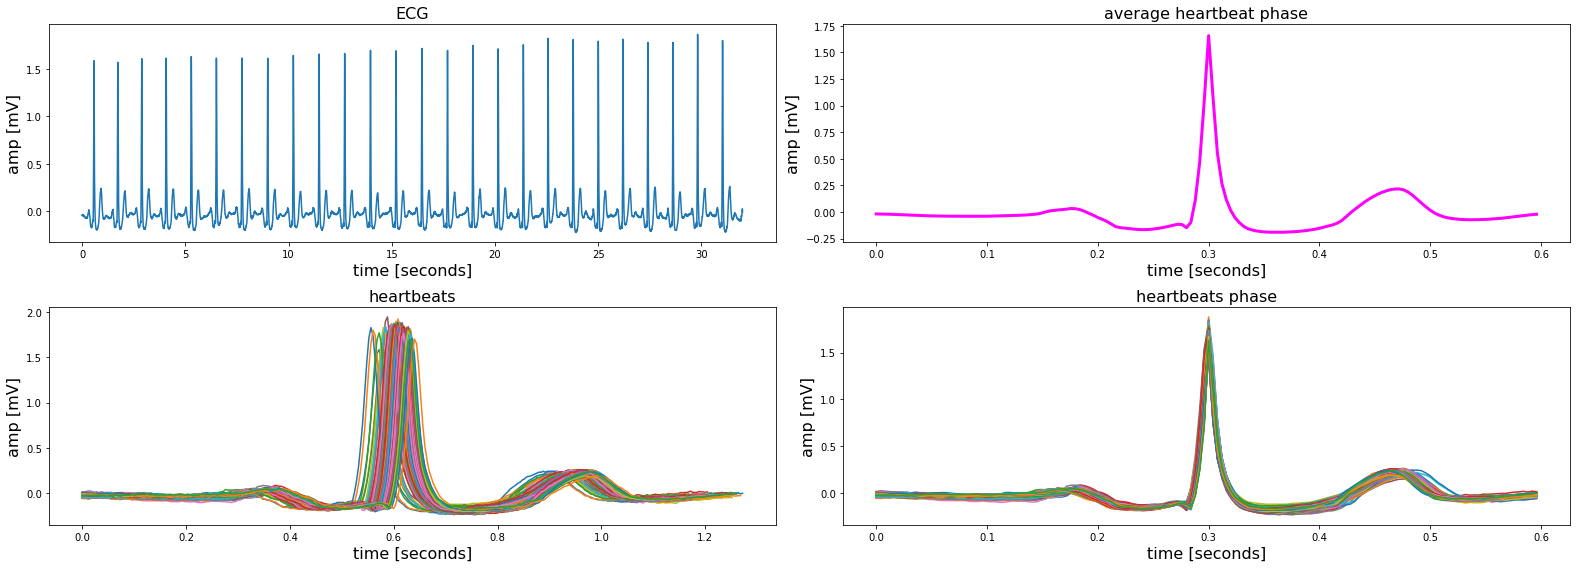

In [52]:
plot_transitionFS2(x, xph, mu_xph, var_xph, fs)

### The sample covariance matrices in phase domain (x_ph and s_ph)

TypeError: only integer scalar arrays can be converted to a scalar index

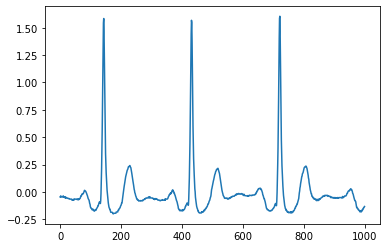

In [53]:
plt.plot(x_f[0:1000])
plt.plot(x_f[ps])

In [ ]:
ps

In [ ]:
plot_sample_covariances(S_xph, var_xph, S_sph, var_sph, 0, 40)

### The inversion

### The choice for the the Rho matrix.

In [ ]:
Rho = 

In [ ]:
plot_ThThT(Theta, Rho, 0, 40)

In [ ]:
plot_transitionFS2(x, xph, mu_xph, var_xph, fs)

In [ ]:
B = np.matmul(Theta, Theta.T)
check_matrix_characteristics(B)
Rho = np.linalg.inv(B) 
C = np.matmul(np.matmul(Theta.T, Rho), Theta)

In [ ]:
fig = plt.figure(figsize = (21,5))    
#-----
plt.subplot(1,3,1)
plt.imshow(B)
plt.colorbar()
#-----
plt.subplot(1,3,2)
st = 0
en = 40
plt.imshow(B[st:en,st:en])
plt.colorbar()
#-----
plt.subplot(1,3,3)
plt.imshow(C[st:en,st:en])
plt.colorbar()
#-----
fig.tight_layout()

In [ ]:
np.matmul(C, np.array(x_f).T)

In [ ]:
plt.plot(mu_xph)

### Get x noisy in phase domain, the transformation matrix and sample statistics

In [ ]:
# x_n in phase domain 
xph_n, Th = get_sigphase_and_transfmat2(x_n, pshb, Tau)      # xph_n is list of transformed heartbeats for x, Theta is the transformation
Theta = create_Theta2(Th)                                    # Theta is formed from each Th_i, by concatenation and normalization
#-----
xph_n_f = np.concatenate(xph_n, axis=0).tolist()            # xph_n_f refers to xph flatten, used in multiplications
mu_xph_n = np.asarray(Theta * np.asmatrix(x_n_f).T)         # mu_xph_n is the mean-binned signal x_n in the phase domain
#-----
S_xph_n, S_sph_n, var_xph_n, var_sph_n = compute_covariance(xph_n, var_n)
sd_xph_n = np.sqrt(var_xph_n)
#----- ---- --- -- -

### Get the noise variance estimation

In [ ]:
# noise variance, estimation via ME
var_n_ME = compute_var_n_ME_v1(x_n_f, mu_xph_n)
sd_n_ME = np.sqrt(var_n_ME)

In [ ]:
print('real var:', var_n)
print('esti var:', var_n_ME)

### Filter the transformation matrix -> smoother estimation

In [ ]:
# Theta is filtered for a smoother filter
ThetaF = np.asmatrix(func_MA_filter_time_phase_matrix(Theta, 5))

### Define matrix Rho 

In [ ]:
#----- ---- --- -- -
Rho_0 = np.identity(Tau)
#s_h0 = compute_GP_filter(Theta, Rho_0, x_n_f)
#input_SNR_db, output_SNR_db_0, delta_SNR_db_0 = compute_all_SNRs(x_f, n, s_h0)
#----- ---- --- -- -
Rho_1 = np.diag(1 - (var_n_ME / (var_n_ME + var_xph_n )))
#s_h1 = compute_GP_filter(Theta, Rho_1, x_n_f)
#input_SNR_db, output_SNR_db_1, delta_SNR_db_1 = compute_all_SNRs(x_f, n, s_h1)
#----- ---- --- -- -
Rho_2 = np.identity(Tau) - var_n_ME * np.linalg.inv(S_xph_n)
#s_h2 = compute_GP_filter(Theta, Rho_2, x_n_f)
#input_SNR_db, output_SNR_db_2, delta_SNR_db_2 = compute_all_SNRs(x_f, n, s_h2)

In [ ]:
Rho_0

In [1]:
Th[0]

NameError: name 'Th' is not defined

In [ ]:
check_matrix_characteristics(B)
fig = plt.figure(figsize = (16,6))    
plt.subplot(1,2,1)
plt.imshow(B)
plt.colorbar()
fig.tight_layout()
plt.subplot(1,2,2)
st = 0
en = 40
plt.imshow(B[st:en,st:en])
plt.colorbar()
fig.tight_layout()

In [ ]:
s_h0 = compute_GP_filter(ThetaF, Rho_0, x_f, mu_xph_n)
inSNRdb, outSNRdb, delSNRdb = compute_all_SNRs(x_f, n, s_h0)
print("inSNR, outSNR, delSNR ", inSNRdb, outSNRdb, delSNRdb)
plot_all(x, xph, var_xph, var_n, np.diag(Rho_0), mu_xph, s_h0, 'x', 'xph', 1400)

In [ ]:
#plot_transition(x, xph, mu_xph, var_xph)

In [ ]:
#plot_transitionFS(x, xph, mu_xph, var_xph, fs)

In [ ]:
#plot_transitionFS2(x, xph, mu_xph, var_xph_n, fs)

In [ ]:
# fig = plt.figure(figsize = (22, 8))
# plt.plot(mu_xph, 'o-')

In [ ]:
#mu_xph.flatten()

In [ ]:
#np.savetxt("ecg.csv", mu_xph.flatten(), delimiter=",")

In [ ]:
#----- ---- --- -- -
# Rho is identity, reconstruction from the clean signal
s_h0 = compute_GP_filter(ThetaF, Rho_0, x_f)
inSNRdb, outSNRdb, delSNRdb = compute_all_SNRs(x_f, n, s_h0)
print("inSNR, outSNR, delSNR ", inSNRdb, outSNRdb, delSNRdb)
plot_all(x, xph, var_xph, var_n, np.diag(Rho_0), mu_xph, s_h0, 'x', 'xph', 1400)
# #----- ---- --- -- -
# Rho is the identity, reconstruction from the noisy signal 
s_h0 = compute_GP_filter(ThetaF, Rho_0, x_n_f)
inSNRdb, outSNRdb, delSNRdb = compute_all_SNRs(x_f, n, s_h0)
print("inSNR, outSNR, delSNR ", inSNRdb, outSNRdb, delSNRdb)
plot_all(x_n, xph_n, var_xph_n, var_n, np.diag(Rho_0), mu_xph_n, s_h0, 'x_n', 'xph_n', 1400)
# #----- ---- --- -- -
# Rho is as per the equations, reconstruction from the clean signal
s_h1 = compute_GP_filter(ThetaF, Rho_1, x_f)
inSNRdb, outSNRdb, delSNRdb = compute_all_SNRs(x_f, n, s_h1)
print("inSNR, outSNR, delSNR ", inSNRdb, outSNRdb, delSNRdb)
plot_all(x, xph_n, var_xph_n, var_n, np.diag(Rho_1), mu_xph_n, s_h1, 'x_n', 'xph_n', 1400)
# #----- ---- --- -- -
# # Rho is as per the equations, reconstruction from the noisy signal
s_h1 = compute_GP_filter(ThetaF, Rho_1, x_n_f)
inSNRdb, outSNRdb, delSNRdb = compute_all_SNRs(x_f, n, s_h1)
print("inSNR, outSNR, delSNR ", inSNRdb, outSNRdb, delSNRdb)
plot_all(x_n, xph_n, var_xph_n, var_n, np.diag(Rho_1), mu_xph_n, s_h1, 'x_n', 'xph_n', 1400)
# #----- ---- --- -- -
# # Rho is as per the equations, full covariance, reconstruction from the noisy signal
s_h2 = compute_GP_filter(ThetaF, Rho_2, x_n_f)
inSNRdb, outSNRdb, delSNRdb = compute_all_SNRs(x_f, n, s_h2)
print("inSNR, outSNR, delSNR ", inSNRdb, outSNRdb, delSNRdb)
plot_all(x_n, xph_n, var_xph_n, var_n, np.diag(Rho_2), mu_xph_n, s_h2, 'x_n', 'xph_n', 1400)
# #----- ---- --- -- -

In [ ]:
inv_S_xph_n = np.linalg.inv(S_xph_n)
fig = plt.figure(figsize = (24,4))    
plt.subplot(1,3,1)
plt.imshow(S_xph_n)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(var_n_ME * inv_S_xph_n)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.identity(Tau) - var_n_ME * inv_S_xph_n)
plt.colorbar()
fig.tight_layout()
plt.show()       

In [ ]:
Stop

In [ ]:
np.sqrt(3)

In [ ]:
1/0.59460356

In [ ]:
cc = np.matmul(Th[0], Th[0].T)
np.linalg.det(cc)

In [ ]:
Th[0][0:5,0:5]

In [ ]:
cc = np.matmul(Th[0], Th[0].T)
plt.imshow(cc[0:10,0:10])
plt.colorbar()

In [ ]:
plt.imshow(Th[0][0:35, 0:35])
plt.colorbar()

In [ ]:
xph, Th = get_sigphase_and_transfmat(x, pshb, 400)

In [ ]:
fig = plt.figure(figsize = (24,4))    
plt.subplot(1,2,1)
for hb in x:
    plt.plot(hb)
plt.subplot(1,2,2) 
for hbph in xph:
    plt.plot(hbph)
fig.tight_layout()
plt.show()       

In [ ]:
STOP

In [ ]:
#srecord = wfdb.rdrecord('Data/s0010_re')
FILE_PATH = os.getcwd()
data_dir = FILE_PATH + '/../QTDataBase/'
data_files = os.listdir(data_dir) # get a listing of the directory
dat_files = [x.split('.')[0] for x in data_files]
#dat_files = sorted([f for f in data_files if f.endswith('.hea')]) # get a list of all the .atc files
#-------
file_name = 'sele0603'
#'sele0603' 'sele0612' 'sel41' 'sele0122' 'sel40' 'sele0612' 'sele0303'
#-------
file_to_read = data_dir + file_name
signals, fields = wfdb.rdsamp(file_to_read, sampfrom=0)
fs = fields["fs"]
ch_num = 0
s = signals[:,ch_num]
#
print("selected file: ", file_name)
print("selected channel: ", ch_num)
#-------
n_sec = 60
N = n_sec * fs 
ecg_clean = s[0: N]
tm = np.arange(0, N)/fs
#-------
bwr, ecg_bwr = func_bw_extraction_MAMD(signal = ecg_clean,
                                       win_l_MA = 0.5,
                                       win_l_MD = 0.71,
                                       fs = fs)
ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq, peaks2, pks = func_detect_peaks(signal = ecg_bwr, 
                                                                             frac = 0.5, 
                                                                             win_l_calib = 0.6, 
                                                                             win_l_peak_search = 0.5, 
                                                                             fs = fs)
mids = func_detect_middles(peaks2, len(ecg_bwr))
pks = func_reorder_peaks(pks, mids)
#-------
# start_ecg = mids[0]
# end_ecg = mids[-1]
# func_plot_check(tm, pks, mids, s, ecg_clean, ecg_bwr, ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq)
#-------
ecg = ecg_bwr[mids[0]:mids[-1]+1]                           # get the ecg, i.e. get the chunck between the first mid and last mid
ps = np.int_(pks - mids[0])                                 # calibrate the peaks, by shifting with the mids[0] 
                                                            # which is the begining of the signal
ms = np.int_(mids - mids[0])                                # calibrate the midles, by shifting with the mids[0] 
                                                            # which is the begining of the signal
pshb = ps - ms[:-1]                                         # the peaks relative to each heartbeat, i.e. the position counting 
                                                            # from the heartbeat begining    
#----- ---- --- -- -
target_noise_db = 0                                         # set the target noise in dB
Tau = 150                                                   # set the number of bins (samples in phase space)
ecg_n, n, var_n = func_add_noise(target_noise_db, ecg)      # get the noisy signal and the added noise signal
sd_n = np.sqrt(var_n)
pshb_aug = np.array([int(Tau/2)]*len(pshb))
#----- ---- --- -- -
x = func_heartbeats(ecg, ms)                                # x is the "pure" ecg, as list of heartbeats
#x = func_augument_data(x, pshb, Tau)
#
print('number of heartbeats:', len(x))
print('hb with smallest samples #:', get_min_max(x)[0])
print('hb with highest samples #:', get_min_max(x)[1])
x_f = np.concatenate(x, axis=0).tolist()                    # x_f refers to x flatten, used in multiplications
#----- ---- --- -- -
x_n = func_heartbeats(ecg_n, ms)                            # x is the "noisy" ecg, as list of noisy heartbeats
#x_n = func_augument_data(x_n, pshb, Tau)
#
print('number of heartbeats:', len(x_n))
print('hb with smallest samples #:', get_min_max(x_n)[0])
print('hb with highest samples #:', get_min_max(x_n)[1])
x_n_f = np.concatenate(x_n, axis=0).tolist()                # x_n_f refers to x_n flatten, used in multiplications


In [ ]:
plt.imshow(Theta*Theta.T)
plt.colorbar()

In [ ]:
test = Th[0]*Th[0].T
plt.imshow(test[0:30,0:30])
plt.colorbar()

In [ ]:
#----- ---- --- -- -
print('target SNR : ', target_noise_db)
print('var_n      : ', var_n)
print('var_n_ME   : ', var_n_ME)
print('max & min var_xph_n : ', np.min(var_xph_n), np.max(var_xph_n))
# print('max & min sdxhb_n_2 : ', np.min(sdxhb_n_2), np.max(sdxhb_n_2))
#----- ---- --- -- -
print("input SNR, output SNR0, delta SNR0 ", input_SNR_db, output_SNR_db_0, delta_SNR_db_0)
print("input SNR, output SNR1, delta SNR1 ", input_SNR_db, output_SNR_db_1, delta_SNR_db_1)
# print("input SNR, output SNR 2, delta SNR 2 ", input_SNR_db, output_SNR_db_2, delta_SNR_db_2)

In [ ]:
#plot_tests(Theta, Rho_1, x_n_f, x_f, s_h1, 1200)

In [ ]:
#plot_tests(Theta, Rho_0, x_n_f, x_f, s_h0, 1200)

In [ ]:
#func_plot_comparison(x_n_f, x_f, s_h1, n, detail = 800, name = 'ISCE' + file_name, noise_db = target_noise_db, algo = 'CC')

In [ ]:
#----- ---- --- -- -
S_xph, S_sph, var_xph, var_sph = compute_covariance(xph, var_n)
sd_xph = np.sqrt(var_xph)
#----- ---- --- -- -
S_xph_n, S_sph_n, var_xph_n, var_sph_n = compute_covariance(xph_n, var_n)
sd_xph_n = np.sqrt(var_xph_n)
#----- ---- --- -- -
# samps, S_xph_v2, S_sph_v2, var_xph_v2, var_sph_v2 = compute_covariance_v2(xph, var_n)
# sd_xph_v2 = np.sqrt(var_xph_v2)
# #----- ---- --- -- -
# samps_n, S_xph_n_v2, S_sph_n_v2, var_xph_n_v2, var_sph_n_v2 = compute_covariance_v2(xph_n, var_n)
# sd_xph_n_v2 = np.sqrt(var_xph_n_v2)
# #----- ---- --- -- -

In [ ]:
#----- ---- --- -- -
# Rho is identity, reconstruction from the clean signal
s_h0 = compute_GP_filter(Theta, Rho_0, x_f)
inSNRdb, outSNRdb, delSNRdb = compute_all_SNRs(x_f, n, s_h0)
print("inSNR, outSNR, delSNR ", inSNRdb, outSNRdb, delSNRdb)
plot_all(x, xph, var_xph, var_n, np.diag(Rho_0), mu_xph, s_h0, 'x', 'xph', 1400)
# #----- ---- --- -- -
# Rho is the identity, reconstruction from the noisy signal 
s_h0 = compute_GP_filter(Theta, Rho_0, x_n_f)
inSNRdb, outSNRdb, delSNRdb = compute_all_SNRs(x_f, n, s_h0)
print("inSNR, outSNR, delSNR ", inSNRdb, outSNRdb, delSNRdb)
plot_all(x_n, xph_n, var_xph_n, var_n, np.diag(Rho_0), mu_xph_n, s_h0, 'x_n', 'xph_n', 1400)
# #----- ---- --- -- -
# # Rho is as per the equations, reconstruction from the clean signal
# s_h1 = compute_GP_filter(Theta, Rho_1, x_f)
# plot_all(x, xph_n, var_xph_n, var_n, np.diag(Rho_1), mu_xph_n, s_h1, 'x_n', 'xph_n', 1400)
# #----- ---- --- -- -
# # Rho is as per the equations, reconstruction from the noisy signal
# s_h1 = compute_GP_filter(Theta, Rho_1, x_n_f)
# plot_all(x_n, xph_n, var_xph_n, var_n, np.diag(Rho_1), mu_xph_n, s_h1, 'x_n', 'xph_n', 1400)
# #----- ---- --- -- -

In [ ]:
plt.imshow(Th[0][240:260,240:260])

In [ ]:
plt.plot(x[0])
plt.plot(xph[0])

In [ ]:
Theta * Theta.T

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(Theta[0:40,0:40])
plt.colorbar()

In [ ]:
pshb

In [ ]:
def func_augument_data(x, Tau):
    y = []
    for i in np.arange(len(x)):        
        x_aug = np.interp(np.linspace(0, len(x[i]), Tau), np.arange(len(x[i])), x[i])
        y.append(x_aug)
    return y

In [ ]:
a = [1,2,3,4]
a[3:]

In [ ]:
def func_augument_data(x, pshb, Tau):
    x_aug = []
    for i in np.arange(len(x)):
        x_aug_1 = np.interp(np.linspace(0, pshb[i], int(Tau/2)), 
                            np.arange(0, pshb[i], 1), 
                            x[i][0:pshb[i]])
        x_aug_2 = np.interp(np.linspace(pshb[i], len(x[i]), int(Tau/2)), 
                            np.arange(pshb[i], len(x[i]), 1), 
                            x[i][pshb[i]:])
        x_aug_c = np.concatenate((x_aug_1, x_aug_2),  axis=None)
        x_aug.append(x_aug_c)
    return x_aug

In [ ]:
x_aug = func_augument_data(x, pshb, Tau)

fig = plt.figure(figsize = (24,6))
for i in np.arange(len(x)):
    plt.plot(np.arange(len(x[i])), x[i])
    plt.plot(np.arange(Tau), x_aug[i])
fig.tight_layout()
plt.show()   

In [ ]:
x_aug = func_augument_data(x, pshb, Tau):
#----- ---- --- -- -
fig = plt.figure(figsize = (24,6))
plt.subplot(2,3,1)
plt.plot(np.arange(0, pshb[i], 1), x[i][0:pshb[i]])
plt.plot(np.arange(0, int(Tau/2), 1), x_aug_1)
plt.subplot(2,3,2)
plt.plot(np.arange(pshb[i], len(x[i]), 1), x[i][pshb[i]:])
plt.plot(np.arange(int(Tau/2), Tau, 1), x_aug_2)
plt.subplot(2,3,3)
plt.plot(np.arange(pshb[i]), x[i][0:pshb[i]])
plt.plot(np.arange(pshb[i], len(x[i]), 1), x[i][pshb[i]:])
plt.subplot(2,3,4)
plt.plot(np.arange(len(x[i])), x[i])
plt.plot(np.arange(Tau), x_aug)
plt.subplot(2,3,5)
plt.plot(np.arange(len(x[i])), x[i])
plt.subplot(2,3,6)
plt.plot(np.arange(Tau), x_aug)
fig.tight_layout()
plt.show()        

In [ ]:
y_1, y_2 = func_augument_data(x, pshb, 500)
fig = plt.figure(figsize = (20,3))
#----- ---- --- -- -
plt.subplot(1,3,1)
for hb in y_1:
    plt.plot(hb)
#----- ---- --- -- -
plt.subplot(1,3,2)
for hb in y_2:
    plt.plot(hb)
#----- ---- --- -- -
fig.tight_layout()
plt.show()        

In [ ]:
Tau = 500
y = np.interp(np.linspace(0, len(x[0]), Tau), np.arange(len(x[0])), x[0])
#
plt.plot(x[0])
plt.plot(np.arange(Tau),y)

In [ ]:
STOP

In [ ]:
# x = np.linspace(0, 2*np.pi, 10)
# y = np.sin(x)
# xvals = np.linspace(0, 2*np.pi, 50)
# yinterp = np.interp(xvals, x, y)
# plt.plot(xvals, yinterp, 'o-')
# plt.plot(x, y, 'o-')

In [ ]:
x

In [ ]:
plt.figure(figsize = (22,5))
for samp_n in samps_n:
    plt.plot(samp_n)
plt.plot(mu_xph_n,
         lw = 1,
         color = 'magenta')  
plt.show()

In [ ]:
#var_n
np.var(n)

In [ ]:
plt.plot(n)

In [ ]:
print(func_SNR_computation(x_f, n))
print(func_SNR_computation(x_f, np.asanyarray(x_n_f)-np.asanyarray(x_f)))

In [ ]:
# bb = np.concatenate(mu_xph, axis=0)
# var_xph
# resu = bb + var_xph
# resu
# #np.concatenate(var_xph, axis = 0)

In [ ]:
mu_xph.tolist()
# var_xph.tolist()

In [ ]:
print(len(np.arange(len(mu_xph))))
print(len(mu_xph))
print(len(var_xph))

In [ ]:
plt.figure(figsize = (22,8))
n = 20
plt.plot(x[0][pshb[0]-n : pshb[0]+n],'o-')
plt.plot(xph[0][int(Tau/2)-n : int(Tau/2)+n], 'o-')

In [ ]:
plt.imshow(Theta * Theta.T)
plt.colorbar()

In [ ]:
plt.imshow(Theta)

In [ ]:
samps, S_xph_v2, S_sph_v2, var_xph_v2, var_sph_v2 = compute_covariance_v2(xph, var_n)
sd_xph_v2 = np.sqrt(var_xph_v2)

samps_n, S_xph_n_v2, S_sph_n_v2, var_xph_n_v2, var_sph_n_v2 = compute_covariance_v2(xph_n, var_n)
sd_xph_n_v2 = np.sqrt(var_xph_n_v2)

In [ ]:
plt.figure(figsize = (20,10))
#----- ---- --- -- -
plt.subplot(3,2,1)
for samp in samps:
    plt.plot(samp)
plt.subplot(3,2,2)
plt.plot(var_xph_v2, label = 'var(xph)')
plt.legend()
#----- ---- --- -- -
plt.subplot(3,2,3)
for samp_n in samps_n:
    plt.plot(samp_n)
plt.subplot(3,2,4)
plt.plot(var_xph_n_v2, label = 'var(xph_n)')
plt.legend()
#----- ---- --- -- -
plt.subplot(3,2,5)
for samp_n in samps_n:
    plt.plot(samp_n)
plt.subplot(3,2,6)
plt.plot(var_xph_n_v2 - var_xph_v2, label = 'var(xph_n) - var(xph)')
#plt.plot(var_n * np.ones(Tau))
plt.legend()

In [ ]:
var_n

In [ ]:
a = []
for samp in samps:
    a.append(samp[0])
    #print(samp[0])
np.mean(a)
np.var(a)

In [ ]:
xph, Theta = func_sig_phased(x, pshb, Tau)
R1 = Theta * Theta.T
R2 = Theta.T * Theta
plt.figure(figsize = (16, 5))
plt.subplot(1, 2, 1)
plt.imshow(R1)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(R2[0:80, 0:80])
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(A[0:55,0:155])

In [ ]:
ThThT = Theta * Theta.T
DIFF = ThThT - np.identity(Tau)
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.imshow(ThThT[0:20,0:20])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(DIFF[0:20,0:20])
plt.colorbar()

In [ ]:
mids.append(mid)

In [ ]:
emp_m_r1_l = []
emp_v_r1_l = []
emp_m_r2_l = []
emp_v_r2_l = []
emp_m_r_l = []
emp_v_r_l = []
nrn_l = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,1000]
for nrn in nrn_l:
    r1 = np.random.normal(0, np.sqrt(1), nrn)
    r2 = np.random.normal(0, np.sqrt(2), nrn)
    r = r1 + r2
    emp_m_r1_l.append(np.mean(r1))
    emp_v_r1_l.append(np.var(r1))
    emp_m_r2_l.append(np.mean(r2))
    emp_v_r2_l.append(np.var(r2))
    emp_m_r_l.append(np.mean(r))
    emp_v_r_l.append(np.var(r))
plt.figure(figsize = (20,6))
plt.subplot(2,1,1)
plt.plot(nrn_l, emp_m_r1_l, label = 'mean r1')    
plt.plot(nrn_l, emp_m_r2_l, label = 'mean r2')    
plt.plot(nrn_l, emp_m_r_l, label = 'mean r1+r2')    
plt.subplot(2,1,2)
plt.plot(nrn_l, emp_v_r1_l, label = 'mean r1')    
plt.plot(nrn_l, emp_v_r2_l, label = 'mean r2')    
plt.plot(nrn_l, emp_v_r_l, label = 'mean r1+r2')    
plt.legend()

In [ ]:
print('means:', np.mean(rnn1), np.mean(rnn2), np.mean(rnn))
print('vars:', np.var(rnn1), np.var(rnn2), np.var(rnn))

In [ ]:
stop

In [ ]:
ThThT[0:10,0:10]

In [ ]:
len(x[0])

In [ ]:
Theta[0,0:30]
Theta[1,0:30]

In [ ]:
plt.imshow(Theta[0:30,0:70])

In [ ]:
xph, binc, Theta, ThetaList = func_sig_phased_v2(x, pshb, Tau)

In [ ]:
A = ThetaList[1]
Res = A * A.T - np.identity(Tau)
plt.imshow(Res[23:27,23:27])
plt.colorbar()

In [ ]:
A.shape[1]

In [ ]:
plt.imshow(A[23:26,65:80])

In [ ]:
A[24,65:80]

In [ ]:
A[25,65:80]

In [ ]:
pshb

In [ ]:
for i in np.arange(A.shape[1]):
    cl = A[:,i]
    print(i, sum(cl>0))

In [ ]:
ps

In [ ]:
a = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [ ]:
l = 5
cu1 = a[:l]
cu2 = a[l:]

In [ ]:
cu1

In [ ]:
def func_mapping_v2(seg, N):
    #print("in func_mapping")
    mapped_seg = []
    bins_count = []
    bin_len = len(seg) / N
    Theta = np.asmatrix(np.zeros((N,len(seg))))
    for i in np.arange(N):            
        if ((i * bin_len)!=0 and (i * bin_len).is_integer()==True):
            print('here')
            chunk_start = int(np.ceil(i * bin_len))+1
        else:
            chunk_start = int(np.ceil(i * bin_len))            
        chunk_end = np.minimum(len(seg), int(np.floor((i+1) * bin_len))+1)
        print(i, chunk_start, chunk_end)        
        chunk = seg[chunk_start : chunk_end]                
        mapped_seg.append(np.sum(chunk)/np.sqrt(len(chunk)))
        bins_count.append(len(seg[int(np.ceil(i * bin_len)) : int(np.floor((i+1) * bin_len))+1]))
        Theta[i,int(np.ceil(i * bin_len)) : np.minimum(len(seg), int(np.floor((i+1) * bin_len))+1)] = 1
    return mapped_seg, bins_count, Theta

In [ ]:
def func_sig_phased_v3(xhb, pshb, N):
    yhb = []
    binc = []
    ThetaList = []
    for i, hb in enumerate(xhb):
        print(i)
        y1, bc1, Th1 = func_mapping_v2(hb[:pshb[i]], int(N/2))
        y2, bc2, Th2 = func_mapping_v2(hb[pshb[i]:], int(N/2))
        y = np.concatenate([y1, y2])
        Th = np.asmatrix(sclin.block_diag(Th1,Th2))
        #print(Th)
        Th = Th/np.sqrt(Th.sum(1))
        #print(Th)
        y = func_interpolate_nans(y)
        bc = np.concatenate([bc1, bc2])                
        #print(len(y1), len(y2), len(y), len(y))
        yhb.append(y)    
        binc.append(bc)
        if i == 0:
            Theta = np.copy(Th)
        else:
            Theta = np.concatenate([Theta,Th], axis=1)
        ThetaList.append(Th)    
    #print(Theta)        
    Theta = Theta/np.sqrt(len(xhb))
    #print(Theta)        
    return yhb, binc, Theta, ThetaList

In [ ]:
yhb, binc, Theta, ThetaList = func_sig_phased_v3(x, pshb, Tau)

In [ ]:
plt.imshow(Theta[60:80,200:220])

In [ ]:
A = ThetaList[0]
plt.figure(figsize = (22,5))
plt.imshow(A[60:80,200:220])

In [ ]:
Res = A * A.T - np.identity(Tau)
plt.imshow(Res[23:27,23:27])
plt.colorbar()

In [ ]:
a = np.array([1,2,3,4,5,np.nan,7,8,np.nan,10,11,12,np.nan,14,15,np.nan,np.nan,np.nan,19])
a

In [ ]:
b = func_interpolate_nans(a)
b

In [ ]:
def func_mapping(seg, Tau):
    mapped_seg = []
    bin_len = len(seg) / Tau
    #print("bin lenght:", bin_len)
    Theta = np.asmatrix(np.zeros((Tau, len(seg))))
    for i in np.arange(Tau):
        chunk_start = set_start(i, bin_len)
        chunk_end = np.minimum(len(seg), int(np.floor((i+1) * bin_len)) + 1)        
        chunk = seg[chunk_start : chunk_end]                
        if(len(chunk) == 0): 
            ratio = np.nan
        else:    
            ratio = np.sum(chunk) / np.sqrt(len(chunk))
        #print(i, chunk_start, chunk_end, ratio)
        mapped_seg.append(ratio)
        Theta[i, chunk_start : chunk_end] = 1    
    return mapped_seg, Theta

In [ ]:
n = 40
t = np.arange(n)
x = np.sin(t)
#-----
Tau = 39
t_aug = np.linspace(0 ,n-1, Tau)
x_aug = np.interp(t_aug,t,x)
fig = plt.figure(figsize = (24,6))
plt.plot(t, x, 'o-', lw = 3,  label = 'x, len = ' + str(len(x)))
plt.plot(t_aug, x_aug, 'o-', lw = 3, label = 'x_aug, len = ' + str(len(x_aug)))
plt.legend( loc = 'lower right', fontsize = 18)
fig.tight_layout()
plt.show()   

In [ ]:
print(t)
print(t_aug)

In [ ]:
a = np.array([3,6,7,8,9,10,12,16,19,21,23,24,16,30,31,33,35,40])
trg = 18
step = len(a) / trg
b = []
for i in np.arange(trg + 1):
    b.append(i * step)
    print(i,b)
for i in np.arange(trg):
    print(i,int(np.ceil(b[i])),int(np.ceil(b[i+1])), a[int(np.ceil(b[i])):int(np.ceil(b[i+1]))])       
    
#c[0] = a[np.floor(b[0]):np.floor(b[1])]   
#print(a)
#print(step)


In [ ]:
x

In [ ]:
def hb_augumentation(hb,Tau):
    t_hb = np.arange(len(hb))
    t_aug = np.linspace(0 ,len(hb)-1, Tau)
    hb_aug = np.interp(t_aug, t_hb, hb)
    return hb_aug.tolist()

In [ ]:
# hb = np.sin(np.arange(20))
# Tau = 14
# hb_aug = hb_augumentation(hb, Tau)

# print(len(hb), len(hb_aug))

In [ ]:
def ecg_augumentation(x, Tau):
    x_aug = x.copy()
    for i in np.arange(len(x_aug)):
        if (len(x_aug[i])<Tau):
            print('data is augumented for hb ',i)
            x_aug[i] = hb_augumentation(x_aug[i],Tau)
    return x_aug

In [ ]:
# x=[np.sin(np.arange(5)), np.cos(np.arange(10)), np.sqrt(np.arange(7))]
# x_aug = ecg_augumentation(x, 8)
# plt.figure(figsize = (24,4))
# plt.subplot(1,2,1)
# for hb in x:
#     plt.plot(hb)
# plt.subplot(1,2,2)
# for hb in x_aug:
#     plt.plot(hb)
# fig.tight_layout()
# plt.show()   

In [ ]:
def get_sigphase_and_transfmat(x, pshb, Tau):
    x_a = []
    xph = []
    Theta = []
    for i, hb in enumerate(x):
        hb1 = hb[0:pshb[i]]
        if(len(hb1) < int(Tau/2)):
            hb1 = hb_augumentation(hb1, int(Tau/2)) 
            Th1 = np.identity(int(Tau/2))
            hb1_ph = hb1
        else:
            Tb1, hb1_ph = map_to_phase(hb1, int(Tau/2))
        hb2 = hb[pshb[i]:]
        if(len(hb2) < int(Tau/2)):
            hb2 = hb_augumentation(hb2,int(Tau/2)) 
            Th2 = np.identity(int(Tau/2))
            hb2_ph = hb2
        else:
            Tb2, hb2_ph = map_to_phase(hb2, int(Tau/2))

        # fabricate the heartbeat as concatenation
        hb = np.concatenate([hb1, hb1])
            
        # fabricate the phase heartbeat as concatenation
        hb_ph = np.concatenate([hb1_ph, hb1_ph])
        
        # fabricate the Th as diagonal concatenation
        Th = np.zeros((Th1.shape[0]+Th2.shape[0], Th1.shape[1]+Th2.shape[1]))
        Th[0:Th1.shape[0],0:Th1.shape[1]] = Th1
        Th[Th1.shape[0]:Th1.shape[0]+Th2.shape[0],Th1.shape[1]:Th1.shape[1]+Th2.shape[1]] = Th2    
        Th = Th/Th.sum(axis=1)[:,None]
    x_a.append(hb)
    xph.append(hb_ph) 
    Theta.append(Th)      
    return x_a, xph, Theta

In [ ]:
Tst = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
Tst

In [ ]:
Tst/Tst.sum(axis=1)[:,None]

In [ ]:
Tst

In [ ]:
plt.imshow(Tst)

In [ ]:
def get_intervals(n,m):
    step = n / (m+1)
    ints = []
    for i in np.arange(m + 1):
        ints.append(i * step)
    return ints

In [ ]:
def get_theta_and_phase(hb, Tau):
    print(len(hb), Tau)
    ints = get_intervals(len(hb), Tau)
    #---
    T = np.zeros((Tau, len(hb)))
    hbph = [] * Tau
    #---
    for i in np.arange(Tau):
        start = int(np.ceil(ints[i]))
        end = int(np.ceil(ints[i+1]))
        if(start == end):
            if(start > 0):
                start = start - 1
            if(end < len(hb)):
                end = end + 1
        T[i, np.arange(start, end)] = 1/np.sqrt(len(hb[start:end]))
        hbph.append(sum(hb[start:end])/np.sqrt(len(hb[start:end])))
    return T, hbph

In [ ]:
def get_sigphase_and_transfmat(x, pshb, Tau):
    xph = []
    Theta = []
    for i, hb in enumerate(x):
        hb1 = hb[0:pshb[i]]
        Th1, hb1_ph = get_theta_and_phase(hb1, int(Tau/2))
        #----- ---- --- -- -    
        hb2 = hb[pshb[i]:]
        Th2, hb2_ph = get_theta_and_phase(hb2, int(Tau/2))
        #----- ---- --- -- -            
        # fabricate the phase heartbeat as concatenation
        hb_ph = np.concatenate([hb1_ph, hb2_ph])        
        # fabricate the Th as diagonal concatenation
        Th = np.zeros((Th1.shape[0] + Th2.shape[0], Th1.shape[1] + Th2.shape[1]))
        Th[0 : Th1.shape[0], 0 : Th1.shape[1]] = Th1
        Th[Th1.shape[0] : Th1.shape[0] + Th2.shape[0], Th1.shape[1] : Th1.shape[1] + Th2.shape[1]] = Th2    
        Th = Th/Th.sum(axis=1)[:,None]
        #----- ---- --- -- -        
        xph.append(hb_ph) 
        Theta.append(Th)      
    return xph, Theta

In [ ]:
# hb1 = np.sin(np.arange(21))
# #hb2 = np.sin(np.arange(24))
# #hb3 = np.sin(np.arange(23))
# #hb4 = np.sin(np.arange(22))
# pshb = [10,12,11,10]
# x = [hb1]
# #x = [hb1,hb2,hb3,hb4]
# Tau = 50
# x_a, xph, Th = get_sigphase_and_transfmat(x, pshb, Tau)
# #Theta = create_Theta(Th)

In [ ]:
#srecord = wfdb.rdrecord('Data/s0010_re')
FILE_PATH = os.getcwd()
data_dir = FILE_PATH + '/../QTDataBase/'
data_files = os.listdir(data_dir) # get a listing of the directory
dat_files = [x.split('.')[0] for x in data_files]
#dat_files = sorted([f for f in data_files if f.endswith('.hea')]) # get a list of all the .atc files
#-------
file_name = 'sele0603'
#'sele0603' 'sele0612' 'sel41' 'sele0122' 'sel40' 'sele0612' 'sele0303'
#-------
file_to_read = data_dir + file_name
signals, fields = wfdb.rdsamp(file_to_read, sampfrom=0)
fs = fields["fs"]
ch_num = 0
s = signals[:,ch_num]
#
print("selected file: ", file_name)
print("selected channel: ", ch_num)
#-------
n_sec = 60
N = n_sec * fs 
ecg_clean = s[0: N]
tm = np.arange(0, N)/fs
#-------
bwr, ecg_bwr = func_bw_extraction_MAMD(signal = ecg_clean,
                                       win_l_MA = 0.5,
                                       win_l_MD = 0.71,
                                       fs = fs)
ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq, peaks2, pks = func_detect_peaks(signal = ecg_bwr, 
                                                                             frac = 0.5, 
                                                                             win_l_calib = 0.6, 
                                                                             win_l_peak_search = 0.5, 
                                                                             fs = fs)
mids = func_detect_middles(peaks2, len(ecg_bwr))
pks = func_reorder_peaks(pks, mids)

ecg = ecg_bwr[mids[0]:mids[-1]+1]                           # get the ecg, i.e. get the chunck between the first mid and last mid
ps = np.int_(pks - mids[0])                                 # calibrate the peaks, by shifting with the mids[0] 
                                                            # which is the begining of the signal
ms = np.int_(mids - mids[0])                                # calibrate the midles, by shifting with the mids[0] 
                                                            # which is the begining of the signal
pshb = ps - ms[:-1]                                         # the peaks relative to each heartbeat, i.e. the position counting 
                                                            # from the heartbeat begining    
#----- ---- --- -- -
target_noise_db = 0                                         # set the target noise in dB
Tau = 150                                                   # set the number of bins (samples in phase space)
ecg_n, n, var_n = func_add_noise(target_noise_db, ecg)      # get the noisy signal and the added noise signal
sd_n = np.sqrt(var_n)
#----- ---- --- -- -
x = func_heartbeats(ecg, ms)                                # x is the "pure" ecg, as list of heartbeats
x_f = np.concatenate(x, axis=0).tolist()                    # x_f refers to x flatten, used in multiplications
#----- ---- --- -- -
x_n = func_heartbeats(ecg_n, ms)                            # x is the "noisy" ecg, as list of noisy heartbeats
x_n_f = np.concatenate(x_n, axis=0).tolist()                # x_n_f refers to x_n flatten, used in multiplications

In [ ]:
pshb

In [ ]:
len(x[0])

In [ ]:
cc = np.matmul(Th[0], Th[0].T)
plt.imshow(cc[0:10,0:10])
plt.colorbar()

In [ ]:
plt.figure(figsize = (24,4))
plt.subplot(1,3,1)
for hb in x:
    plt.plot(hb, '-')
plt.subplot(1,3,2)
for hb in xa:
    plt.plot(hb, '-')
plt.subplot(1,3,3)
for hb in xph:
    plt.plot(hb, '-')
fig.tight_layout()
plt.show()   

In [ ]:
Theta = create_Theta(Th)
res = Theta * Theta.T
plt.imshow(res[0:30,0:30])
plt.colorbar()

In [ ]:
#----- ---- --- -- -
# x in phase domain 
xph, Th = func_sig_phased(x, pshb, Tau)                    # xph is list of transformed heartbeats for x, Theta is the transformation
xa, xph, Th = get_sigphase_and_transfmat(x, pshb, Tau)
# xph, Th = func_sig_phased(x, pshb_aug, Tau)                 # xph is list of transformed heartbeats for x, Theta is the transformation
Theta = create_Theta(Th)
xph_f = np.concatenate(xph, axis=0).tolist()                # xph_f refers to xph flatten, used in multiplications
mu_xph = np.asarray(Theta * np.asmatrix(x_f).T)             # mu_xph is the mean-binned signal x in the phase domain
#----- ---- --- -- -
# x_n in phase domain 
xph_n, Th = func_sig_phased(x_n, pshb, Tau)                 # xph_n is list of transformed heartbeats for x, Theta is the transformation
# xph_n, Th = func_sig_phased(x_n, pshb_aug, Tau)             # xph_n is list of transformed heartbeats for x, Theta is the transformation
Theta = create_Theta(Th)
xph_n_f = np.concatenate(xph_n, axis=0).tolist()            # xph_n_f refers to xph flatten, used in multiplications
mu_xph_n = np.asarray(Theta * np.asmatrix(x_n_f).T)         # mu_xph_n is the mean-binned signal x_n in the phase domain
#----- ---- --- -- -
# noise variance, estimation via ME
var_n_ME = compute_var_n_ME_v1(x_n_f, mu_xph_n)
sd_n_ME = np.sqrt(var_n_ME)
#----- ---- --- -- -
S_xph_n, S_sph_n, var_xph_n, var_sph_n = compute_covariance(xph_n, var_n)
sd_xph_n = np.sqrt(var_xph_n)
# sd_sph_n = np.sqrt(var_sph_n)
# S_xph_n, S_sph_n, var_xph_n, var_sph_n = compute_covariance_v2(xph_n, var_n)
# sd_xph_n = np.sqrt(var_xph_n)
# #sd_sph_n = np.sqrt(var_sph_n)
#----- ---- --- -- -
Theta = np.asmatrix(func_MA_filter_time_phase_matrix(Theta, 5))
#----- ---- --- -- -
Rho_0 = np.identity(Tau)
s_h0 = compute_GP_filter(Theta, Rho_0, x_n_f)
input_SNR_db, output_SNR_db_0, delta_SNR_db_0 = compute_all_SNRs(x_f, n, s_h0)
#----- ---- --- -- -
# input_SNR_db = func_SNR_computation(x_f, n)
# output_SNR_db_0 = func_SNR_computation(x_f, (s_h0 - x_f))
# delta_SNR_db_0 = output_SNR_db_0 - input_SNR_db
# print("flag 6")
#----- ---- --- -- -
Rho_1 = np.diag(1 - (var_n_ME / (var_n_ME + var_xph_n )))
s_h1 = compute_GP_filter(Theta, Rho_1, x_n_f)
input_SNR_db, output_SNR_db_1, delta_SNR_db_1 = compute_all_SNRs(x_f, n, s_h1)
#----- ---- --- -- -
# input_SNR_db = func_SNR_computation(x_f, n)
# output_SNR_db_1 = func_SNR_computation(x_f, (s_h1 - x_f))
# delta_SNR_db_1 = output_SNR_db_1 - input_SNR_db
# print("flag 7")
#----- ---- --- -- -

In [ ]:
plt.figure(figsize = (24,4))    
plt.subplot(2,2,1)
for hb in x:
    plt.plot(hb)
plt.subplot(2,2,2)
for hb in x_a:
    plt.plot(hb)
plt.subplot(2,2,3)
for hb in xph:
    plt.plot(hb)
plt.subplot(2,2,4)
#plt.imshow(Theta)
fig.tight_layout()
plt.show()   

In [ ]:
plt.figure(figsize = (24,4))    
plt.subplot(2,2,1)
plt.imshow(T)
plt.subplot(2,2,2)
plt.imshow(np.matmul(T, T.T))
plt.subplot(2,2,3)
plt.plot(hb)
plt.subplot(2,2,4)
plt.plot(hbph)
fig.tight_layout()
plt.show()   

In [ ]:
trg = 18
step = len(a) / trg
b = []
for i in np.arange(trg + 1):
    b.append(i * step)
    print(i,b)


    
#c[0] = a[np.floor(b[0]):np.floor(b[1])]   
#print(a)
#print(step)